In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from timeit import default_timer as timer
from numba import autojit
from numba import cuda
from numba import *

In [2]:
def colors_img_gen(green=0):
    width = height = 256
    img = np.zeros((width, height, 3), dtype = np.uint8)
    for x in range(width):
        img[:, x] = np.full((256, 3), np.array([x, green, 255-x]), dtype= np.uint8)
    return img

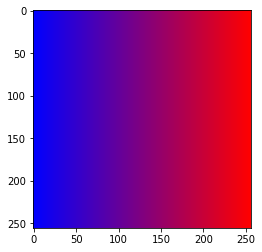

In [4]:
img = colors_img_gen()
plt.imshow(img, animated=True)

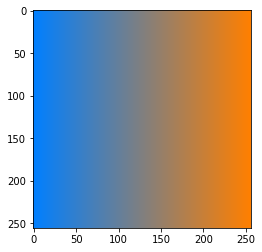

In [5]:
img = colors_img_gen(255/2)
plt.imshow(img, animated=True)

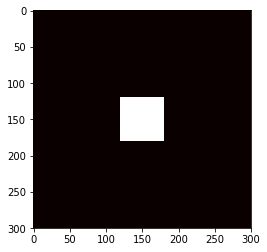

In [2]:
width, height = 300, 300
max_red = 1
ratio = 5
green = max_red / 2
size = (width/(ratio * 2), height/ (ratio * 2))
values = np.zeros((height, width), dtype = np.float64)
Lu = np.zeros((height, width), dtype=np.float64)
center_indxs = int(height/2 - size[0]), int(height/2 + size[0]), int(width/2 - size[1]), int(width/2 + size[1]) 
values[center_indxs[0]: center_indxs[1], center_indxs[2]: center_indxs[3]] = np.array(1)
plt.set_cmap('hot')
im = plt.imshow(values, animated=True)

In [3]:
def check_image_square(c=0):
    return values[center_indxs[0] - c: center_indxs[1] + c, center_indxs[2] - c: center_indxs[3] + c]

In [7]:
def laplacian_cell(values, x, y):
    Lu[x, y] = np.sum(values[x - 1: x + 2, y] + values[x, y - 1: y + 2]) - 6 * values[x, y]

In [8]:
def one_iter(*args):
    dt=0.1
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            laplacian_cell(values, x, y)
    
    values[1:-1, 1:-1] +=  dt * Lu[1:-1, 1:-1]
    im.set_array(values)
    return im,

In [7]:
one_iter()

(<matplotlib.image.AxesImage at 0x202e8e9d278>,)

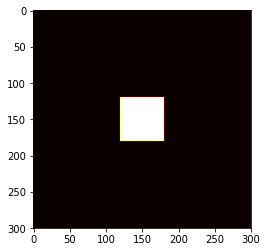

In [8]:
plt.imshow(values)

In [9]:
for _ in range(100):
    one_iter()

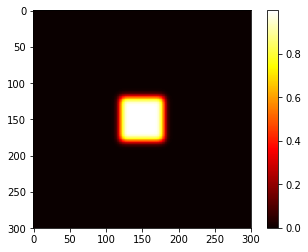

In [10]:
plt.imshow(values)
plt.colorbar()

Better version with numpy

In [3]:
from scipy.ndimage.filters import laplace

In [4]:
# better one itter version
def one_iter_np(*args):
    dt=0.1
    values[1:-1, 1:-1] +=  dt * laplace(values)[1:-1, 1:-1]
    im.set_array(values)
    return im,

In [27]:
for _ in range(1000):
    one_iter_np()
plt.imshow(values)

LETS ANIMATE

<IPython.core.display.Javascript object>


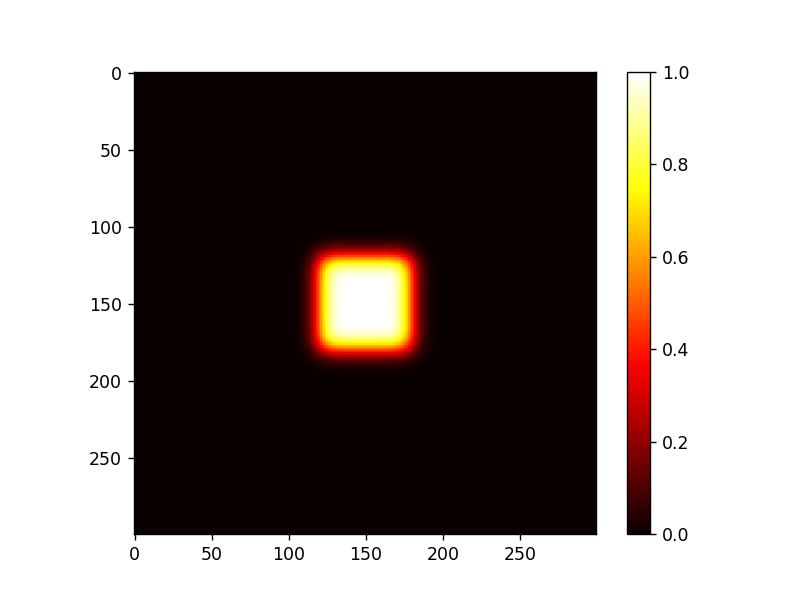

In [5]:
%matplotlib notebook
fig = plt.figure()
im = plt.imshow(values, animated=True)
plt.colorbar()
# here you c
ani = FuncAnimation(fig, one_iter_np, interval=10, blit=True)
plt.show()